In [1]:
from pathlib import Path
from typing import Callable, Dict, Optional
import numpy as np
import sys
sys.path.append('..')
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from skimage import io
from torchvision.transforms import ToTensor, Resize, CenterCrop
from data_handling.base import BaseDataModuleClass
from datetime import datetime
from data_handling.caching import SharedCache
from hydra import compose, initialize
# from data_handling.chest_xray import MimicDataset, MimicDataModule
from data_handling.sampler import SamplerFactory
from torch.utils.data import DataLoader
from causal_models.train_setup import setup_dataloaders
import matplotlib.pyplot as plt
from tqdm import tqdm
# from data_handling.exclude_id_padchest import exclude_idx

In [2]:
class Hparams:
    def update(self, dict):
        for k, v in dict.items():
            setattr(self, k, v)

args = Hparams()
args.hps = "padchest224_224_with_seg"
args.parents_x = ["sex", "age"]
args.data = Hparams()
args.data.seg_target_list=["Left-Lung", "Right-Lung", "Heart"]
args.batch_size = 1
dataloaders = setup_dataloaders(args=args, cache=False, shuffle_train=False)

{'project_name': 'chest X ray generation', 'seed': 11, 'mixed_precision': False, 'is_unit_test_config': False, 'data': {'batch_size': 1, 'num_workers': 12, 'pin_memory': True, 'input_channels': 1, 'weights': 'None', 'augmentations': {'resize': [224, 224], 'center_crop': 'None', 'random_rotation': 0, 'horizontal_flip': False, 'vertical_flip': False, 'random_crop': 'None', 'random_color_jitter': 0.1, 'random_erase_scale': [0.0, 0.0], 'sharp': 0.0}, 'prop_train': 1.0, '_target_': 'data_handling.pad_chest.PadChestDataModule', 'dataset': 'PadChest', 'domain': 'None', 'cache': False, 'seg_target_list': ['Left-Lung', 'Right-Lung', 'Heart']}, 'trainer': {'name': 'base', 'lr': 0.001, 'num_epochs': 400, 'patience_for_scheduler': 10, 'metric_to_monitor': 'Val/loss', 'metric_to_monitor_mode': 'min', 'val_check_interval': 'None', 'weight_decay': 0.0, 'use_train_augmentations': True, 'loss': 'ce', 'contrastive_temperature': 0.1, 'return_two_views': False, 'finetune_path': 'None', 'device': [0], 'max

/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/padchest.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/padchest.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/vol/biomedic3/tx1215/heartflow_mimic_crop/data_handling/../data_handling/padchest.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Len 61714
pneumonia
False    0.967706
True     0.032294
Name: proportion, dtype: float64
PatientSex_DICOM
F    0.508912
M    0.491088
Name: proportion, dtype: float64
Len 6911
pneumonia
False    0.962958
True     0.037042
Name: proportion, dtype: float64
PatientSex_DICOM
F    0.51541
M    0.48459
Name: proportion, dtype: float64
Len 17123
pneumonia
False    0.965543
True     0.034457
Name: proportion, dtype: float64
PatientSex_DICOM
F    0.500847
M    0.499153
Name: proportion, dtype: float64
Dataset size (3.2 GiB) fits in cache limit (24 GiB). Allocating space to cache all 17123 samples.


In [3]:
train_set = dataloaders['valid'].dataset

### Try to find abnormal cases


Processing subjects:   5%|▍         | 10/216 [00:17<04:43,  1.38s/it]

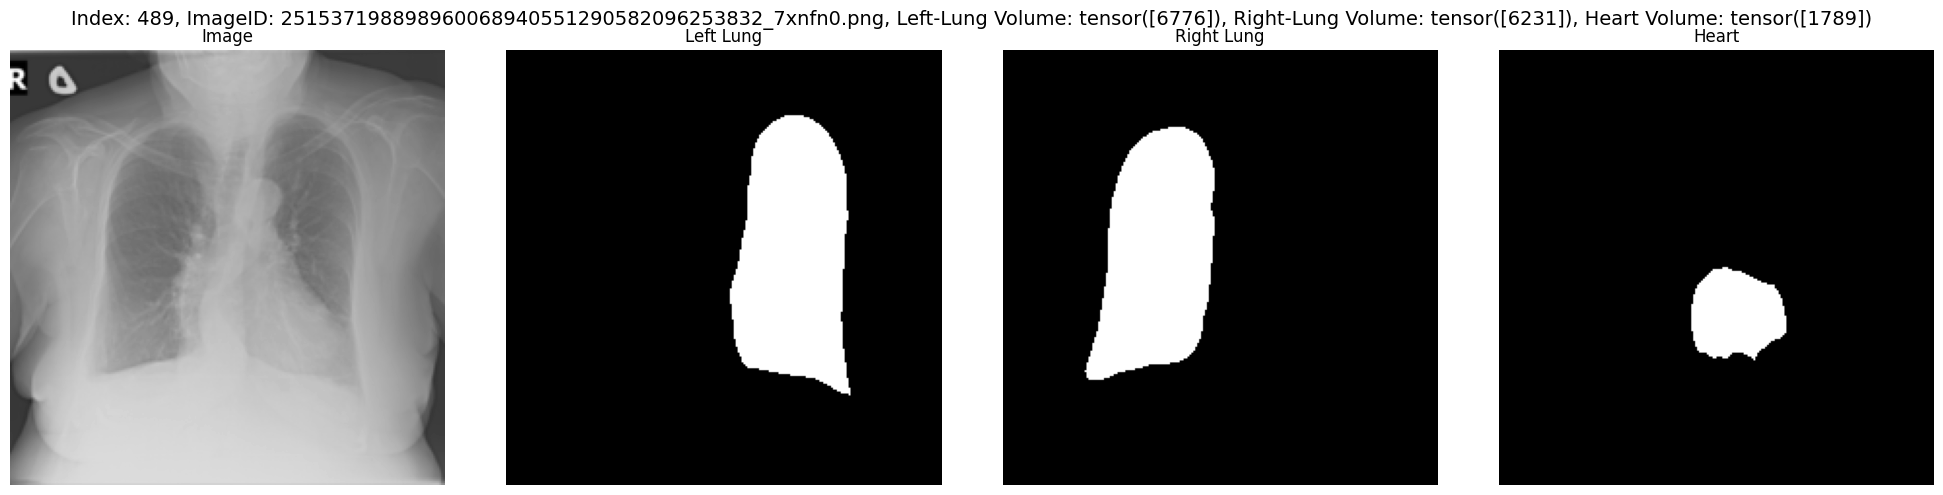

Processing subjects:  16%|█▌        | 34/216 [00:46<04:05,  1.35s/it]

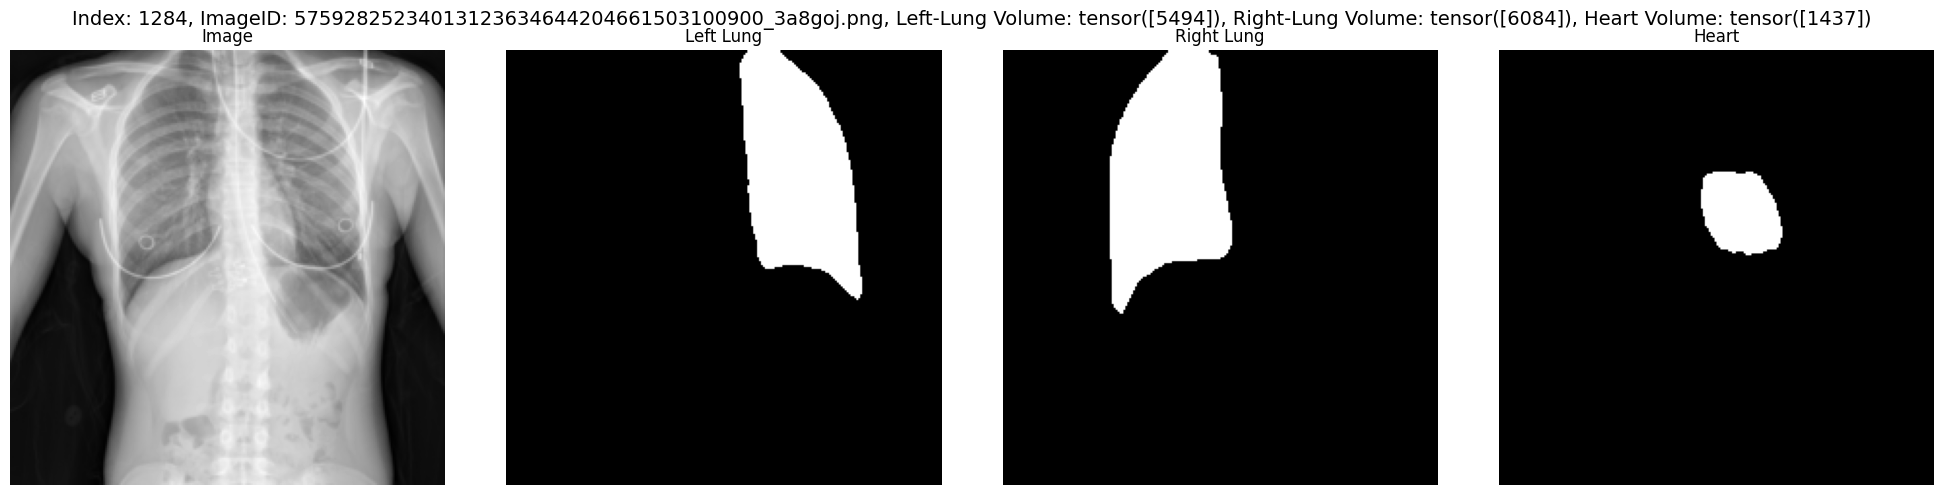

Processing subjects:  71%|███████   | 153/216 [02:26<00:40,  1.57it/s]

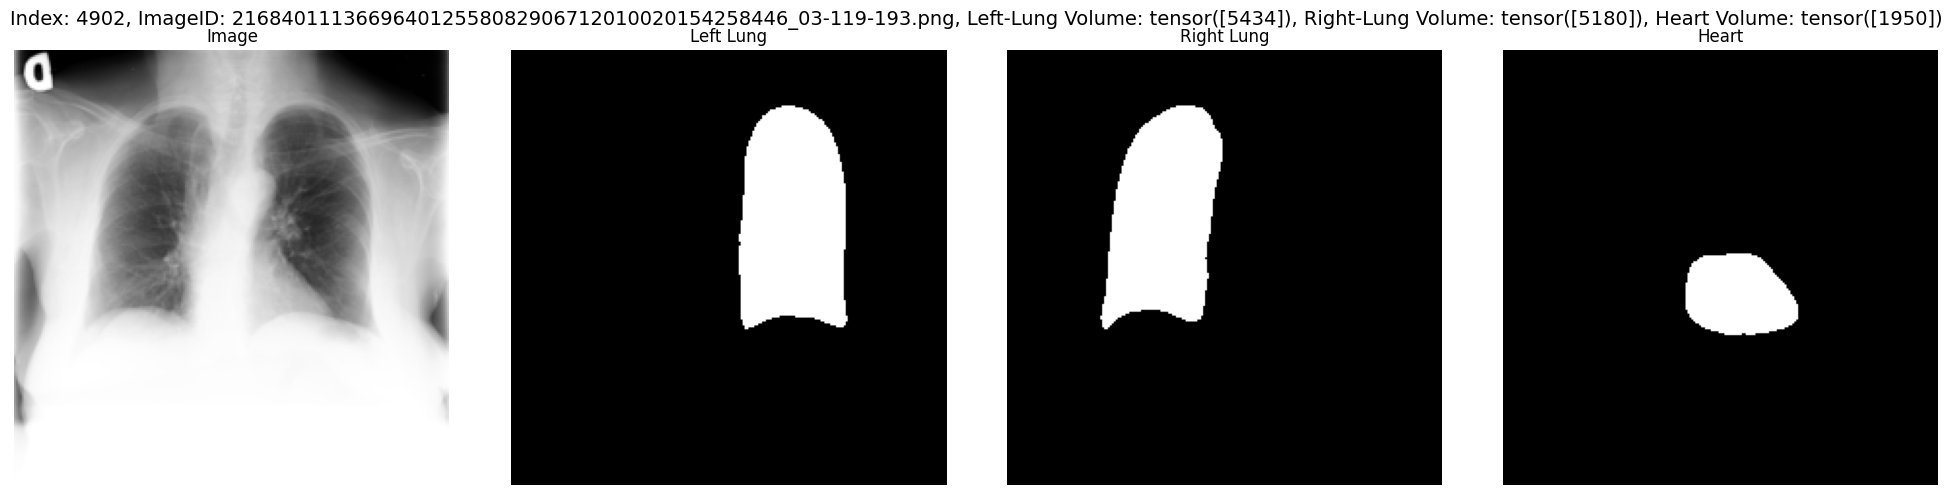

Processing subjects:  82%|████████▏ | 178/216 [02:52<00:34,  1.11it/s]

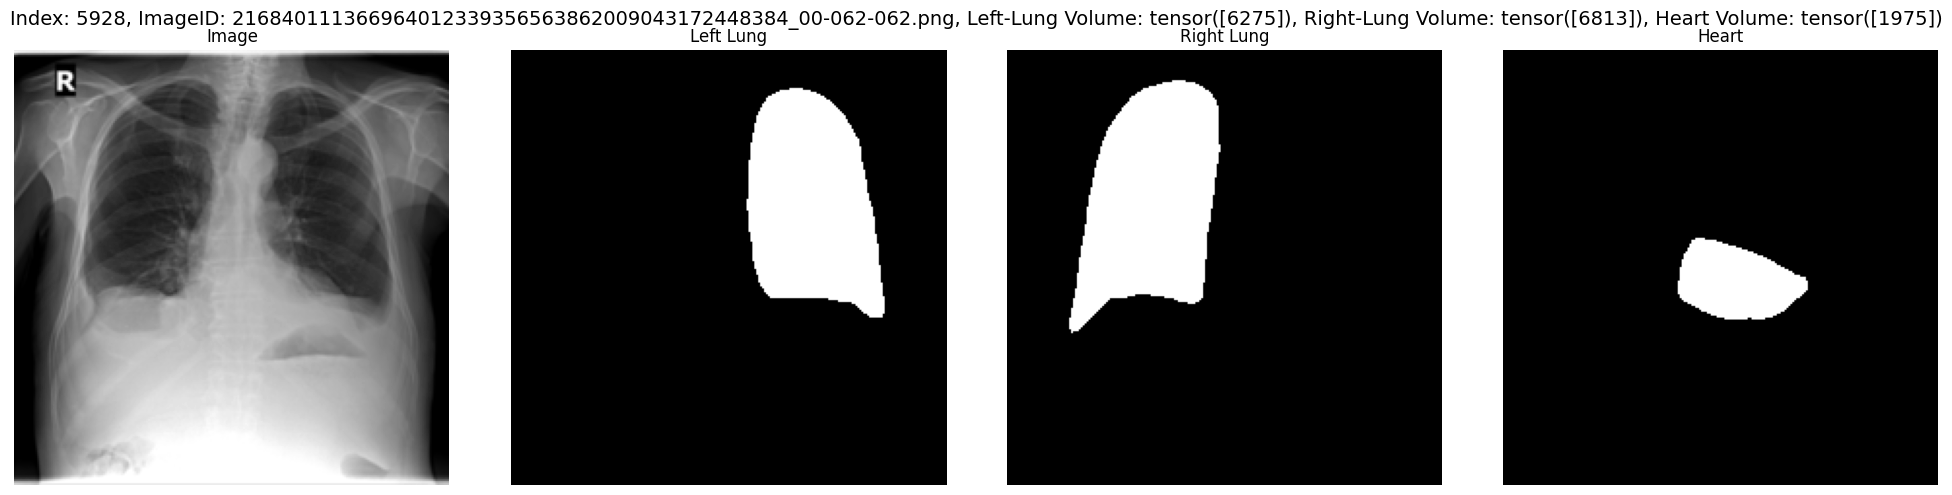

Processing subjects:  94%|█████████▎| 202/216 [03:10<00:12,  1.08it/s]

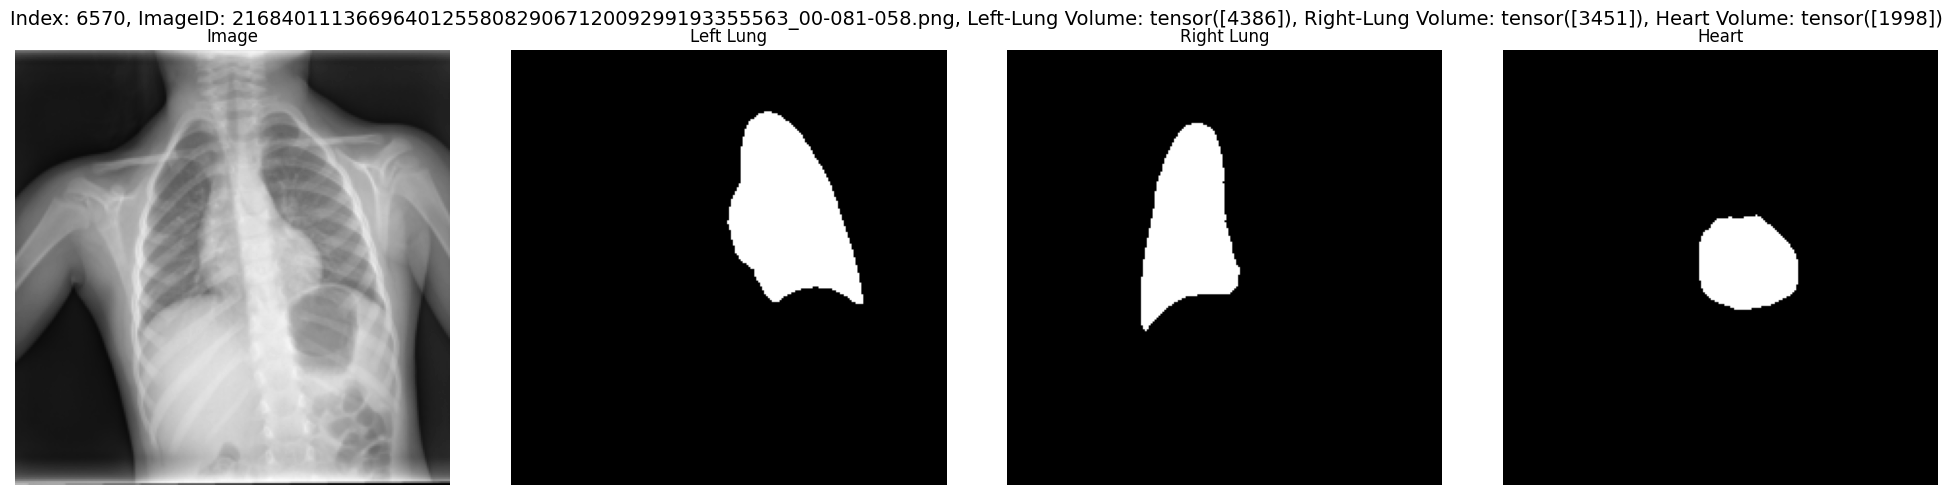

Processing subjects:  97%|█████████▋| 210/216 [03:15<00:05,  1.14it/s]

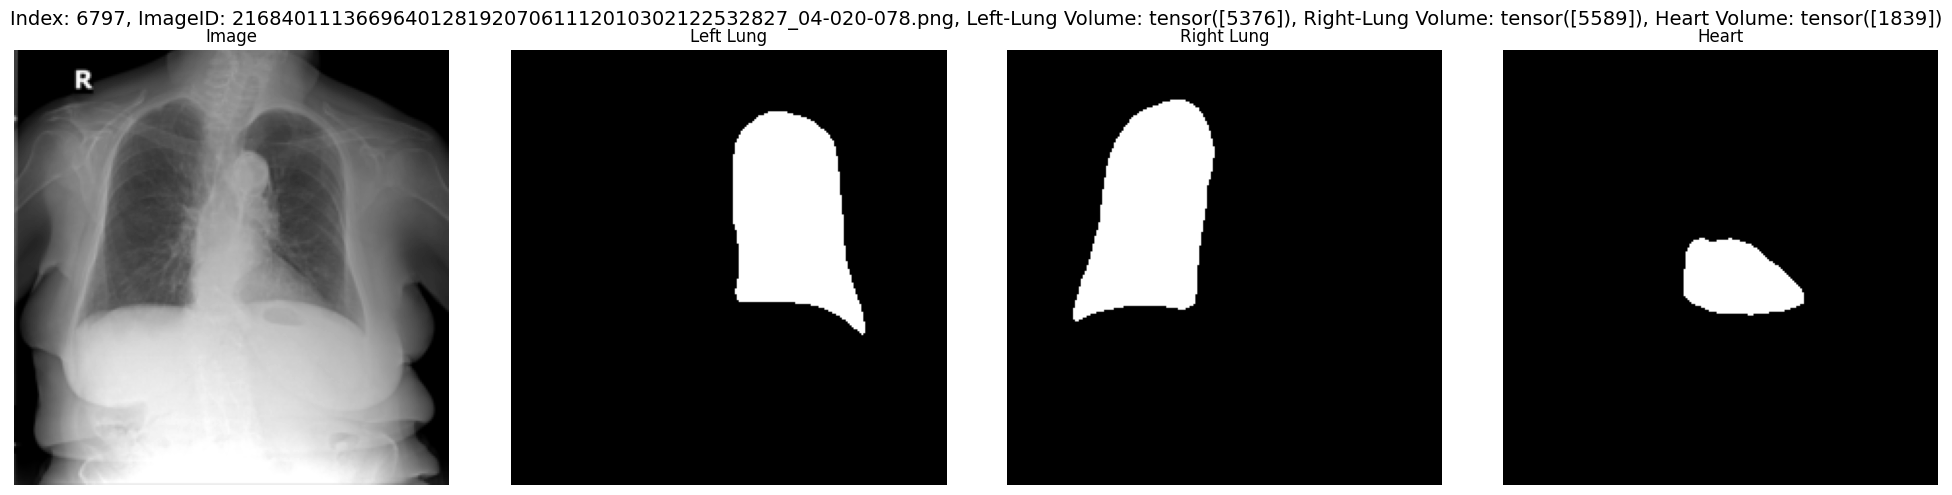

Processing subjects: 100%|██████████| 216/216 [03:15<00:00,  1.10it/s]

Selected ImageIDs: ['251537198898960068940551290582096253832_7xnfn0.png', '57592825234013123634644204661503100900_3a8goj.png', '216840111366964012558082906712010020154258446_03-119-193.png', '216840111366964012339356563862009043172448384_00-062-062.png', '216840111366964012558082906712009299193355563_00-081-058.png', '216840111366964012819207061112010302122532827_04-020-078.png']
Selected IDs: [tensor(489), tensor(1284), tensor(4902), tensor(5928), tensor(6570), tensor(6797)]


In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Function to plot images for a single example
def plot_images(example_batch, idx):
    """
    Plots images from an example batch with detailed titles.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

    # Set the main title for the figure
    fig.suptitle(
        f"Index: {idx}, ImageID: {example_batch['shortpath']}, "
        f"Left-Lung Volume: {example_batch['Left-Lung_volume']}, "
        f"Right-Lung Volume: {example_batch['Right-Lung_volume']}, "
        f"Heart Volume: {example_batch['Heart_volume']}",
        fontsize=14
    )

    # Titles and corresponding keys for the images
    keys_titles = [
        ("x", "Image"),
        ("Left-Lung", "Left Lung"),
        ("Right-Lung", "Right Lung"),
        ("Heart", "Heart"),
    ]

    # Plot images
    for ax, (key, title) in zip(axes, keys_titles):
        if key in example_batch:
            ax.imshow(example_batch[key][0], cmap='gray')
        ax.set_title(title)
        ax.axis("off")  # Hide axes for a cleaner look

    plt.tight_layout()
    plt.show()

# List to store ImageIDs of subjects in the specified range
selected_ImageIDs = []
selected_IDs = []

# Create a DataLoader for the dataset
data_loader = DataLoader(train_set, batch_size=32, shuffle=False, num_workers=8)

# Iterate over the dataset with a progress bar
for batch_idx, batch in tqdm(enumerate(data_loader), desc="Processing subjects", total=len(data_loader)):
    # Check all subjects in the batch
    selected_indices = (
        ((batch['Left-Lung_volume'] >= 0) & (batch['Left-Lung_volume'] < 100)) |
        ((batch['Right-Lung_volume'] >= 0) & (batch['Right-Lung_volume'] < 100)) |
        ((batch['Heart_volume'] >= 1200) & (batch['Heart_volume'] < 2000))
    )

    # Process subjects in the selected range
    for i in selected_indices.nonzero(as_tuple=True)[0]:
        global_idx = batch_idx * 32 + i  # Calculate global index
        example_batch = {key: batch[key][i] for key in batch}  # Extract the selected example

        # Add the ImageID to the list
        selected_ImageIDs.append(example_batch['shortpath'])
        selected_IDs.append(global_idx)
        # Plot the images for the current example
        plot_images(example_batch, global_idx)

# Print the list of selected ImageIDs
print("Selected ImageIDs:", selected_ImageIDs)
print("Selected IDs:", selected_IDs)


### Update abnormal Image IDs based on observation

In [5]:
bad_IDs = []

In [6]:
for id_ in bad_IDs:
    example_batch = train_set.__getitem__(id_)


    # Create a figure with four subplots in a 1x4 grid
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

    # Set the main title for the figure
    fig.suptitle(
            f"Index: {id_}, ImageID: {example_batch['shortpath']}, "
            f"Left-Lung Volume: {example_batch['Left-Lung_volume']}, "
            f"Right-Lung Volume: {example_batch['Right-Lung_volume']}, "
            f"Heart Volume: {example_batch['Heart_volume']}",
            fontsize=14
        )

    # Plot the 'x' image in the first subplot
    axes[0].imshow(example_batch['x'][0], cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")  # Hide axes for a cleaner look

    # Plot the 'Left-Lung' image in the second subplot
    axes[1].imshow(example_batch['Left-Lung'][0], cmap='gray')
    axes[1].set_title("Left Lung")
    axes[1].axis("off")

    # Plot the 'Right-Lung' image in the third subplot
    axes[2].imshow(example_batch['Right-Lung'][0], cmap='gray')
    axes[2].set_title("Right Lung")
    axes[2].axis("off")

    # Plot the 'Heart' image in the fourth subplot
    axes[3].imshow(example_batch['Heart'][0], cmap='gray')
    axes[3].set_title("Heart")
    axes[3].axis("off")

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

In [7]:
# Read the CSV
manual_df = pd.read_csv("manual_labelled_padchest.csv")

# Ensure train_set is defined and contains the required data
# Assuming train_set.__getitem__() returns a dictionary with 'shortpath'

# Create the 'bad' column if it doesn't exist
if 'bad' not in manual_df.columns:
    manual_df['bad'] = 0  # Default to 0 for all rows

# Loop through bad_IDs and update the 'bad' column in manual_df
for id_ in bad_IDs:
    sample = train_set.__getitem__(id_)
    shortpath = sample['shortpath']  # The specific shortpath
    # Locate rows in manual_df where 'ImageID' matches the shortpath
    manual_df.loc[manual_df['ImageID'] == shortpath, 'bad'] = 1

# Save the updated DataFrame back to the CSV file
manual_df.to_csv("manual_labelled_padchest.csv", index=False)

# Optional: Print a confirmation
print("The 'bad' column has been updated for rows matching the bad_IDs.")


The 'bad' column has been updated for rows matching the bad_IDs.


In [8]:
# Assuming bad_IDs is defined

# Read the CSV
manual_df = pd.read_csv("manual_labelled_padchest.csv")

# Ensure train_set is defined and contains the required data
# Assuming train_set.__getitem__() returns a dictionary with 'shortpath'
subset_list = []

# Loop through bad_IDs and get the subset of manual_df
for id_ in bad_IDs:
    sample = train_set.__getitem__(id_)
    shortpath = sample['shortpath']  # The specific shortpath
    subset = manual_df[manual_df['ImageID'] == shortpath]  # Filter manual_df
    subset_list.append(subset)

# Combine all subsets into one DataFrame (if needed)
final_subset = pd.concat(subset_list, ignore_index=True)

# Print the final subset
print(final_subset)


ValueError: No objects to concatenate

### Find max and min volumes of each seg

In [ ]:
modes = ['train', 'valid', 'test']

# Initialize dictionaries for min and max volumes and their indices
seg_target_list = dataloaders['train'].dataset.seg_target_list
min_volumes = {k: float('inf') for k in seg_target_list}
max_volumes = {k: float('-inf') for k in seg_target_list}
min_index = {k: -1 for k in seg_target_list}
max_index = {k: -1 for k in seg_target_list}

# Iterate through modes and datasets
for mode in modes:
    print(f"Processing mode: {mode}")
    
    for idx, batch in enumerate(tqdm(dataloaders[mode], desc=f"Processing {mode} mode")):
        for k in seg_target_list:
            # Extract volume for the current segmentation target
            volume = batch[f"{k}_volume"]

            # Update min volume and index
            current_min = volume.min().item()
            if current_min < min_volumes[k]:
                min_volumes[k] = current_min
                min_index[k] = idx

            # Update max volume and index
            current_max = volume.max().item()
            if current_max > max_volumes[k]:
                max_volumes[k] = current_max
                max_index[k] = idx

# Print results
print("Max Volumes:", max_volumes)
print("Min Volumes:", min_volumes)
print("Min Indices:", min_index)
print("Max Indices:", max_index)
